# Project Setup

## Imports

In [1]:
import librosa
import numpy as np
import pandas as pd
import os
import sys
import pickle
import matplotlib.pyplot as plt
import sklearn as sk
import pywt
import skl2onnx
import tensorflow as tf
import tensorflow_hub as hub

sys.path.append(os.getcwd())

import python_utils

print(tf.__version__)

2025-03-17 15:49:11.515685: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-03-17 15:49:11.520879: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-03-17 15:49:11.537419: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1742251751.567275  523185 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1742251751.576006  523185 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1742251751.598856  523185 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linkin

2.19.0


## Global Variables

In [2]:
PREPROCESSED_DATA_FILE = os.path.join("no_ground_hits", "preprocessed_data", "preprocessed_data_2025-03-17 12:04:55.941999.pkl")
TRAINED_MODELS_DIR = os.path.join("no_ground_hits", "trained_models")
TRAIN_PROPORTION = 0.66
RANDOM_SEED = 42
WINDOW_SIZE = 6616 # From preprocessing.ipynb
SAMPLE_RATE = 22050 # From preprocessing.ipynb

In [3]:
np.random.seed(RANDOM_SEED)

# Load Data

In [4]:
with open(PREPROCESSED_DATA_FILE, 'rb') as file:
    tracker = pickle.load(file)

print(tracker.keys())
python_utils.custom_print(tracker)

dict_keys(['PXL_20250222_012947893.TS_1', 'PXL_20250223_164224211.TS_1', 'PXL_20250222_012947893.TS_2', 'PXL_20250222_013140200.TS_1', 'PXL_20250223_164321190.TS_1', 'PXL_20250223_164250127.TS_1'])
{
  'PXL_20250222_012947893.TS_1': {
    'x': array([[ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00, ...,
         7.3242560e-04,  7.0753385e-04,  7.3038030e-04],
       [ 6.8282022e-04,  6.7373691e-04,  4.2436406e-04, ...,
         1.0909824e-04,  1.5050969e-03,  2.6611104e-03],
       [ 3.4842943e-03,  3.9587440e-03,  4.0320847e-03, ...,
        -4.6930549e-04, -8.7165259e-05,  2.9021440e-04],
       ...,
       [-2.3366683e-03, -1.2868965e-03, -4.8474519e-04, ...,
         2.3729303e-03,  2.8112328e-03,  2.3666527e-03],
       [ 8.1231265e-04, -7.0396642e-04, -1.4670453e-03, ...,
        -2.5612016e-03, -2.3966371e-03, -1.1908840e-03],
       [ 1.4526818e-03,  4.1987905e-03,  6.5072370e-03, ...,
         0.0000000e+00,  0.0000000e+00,  0.0000000e+00]], dtype=float32)
    'x_spectrogram':

# Preprocess
* Audio data are transformed into decible Mel spectograms (2D arrays) for some models

In [5]:
def transform_audio_to_spectrogram(audio_values: np.array, top_db: float = 75.0) -> np.array:
    """Transform audio values into a magnitude spectrogram in decibels,
       ensuring the output has the same number of time frames as the input.
    """
    audio_stft = librosa.stft(
        y=audio_values,
        # n_fft=audio_values.shape[0] / ,
    )
    audio_abs = np.abs(audio_stft)
    audio_db = librosa.amplitude_to_db(audio_abs, top_db=top_db)
    return audio_db


def transform_audio_to_mel_spectrogram(audio_values: np.array, sr: int, n_mels: int = 128, top_db: float = 80.0) -> np.array:
    """Transform audio values into a Mel spectrogram in decibels.

    Args:
        audio_values: The audio waveform as a NumPy array.
        sr: The sampling rate of the audio.
        n_mels: The number of Mel bands to use.
        top_db: The maximum decibel value to use.

    Returns:
        The Mel spectrogram as a NumPy array.
    """
    mel_spectrogram = librosa.feature.melspectrogram(y=audio_values, sr=sr, n_mels=n_mels)
    mel_db = librosa.power_to_db(mel_spectrogram, top_db=top_db)
    return mel_db

In [6]:
for base_name in tracker:
  tracker[base_name]["x_spectrogram"] = np.array([transform_audio_to_mel_spectrogram(
      audio_values=tracker[base_name]["x"][i],
      sr=SAMPLE_RATE,
      n_mels=256,  # Changed to 256 for more resolution
  ) for i in range(len(tracker[base_name]["x"]))])

In [7]:
for base_name in tracker:
    print(base_name)
    print(tracker[base_name]["x_spectrogram"].shape)

PXL_20250222_012947893.TS_1
(60, 256, 13)
PXL_20250223_164224211.TS_1
(104, 256, 13)
PXL_20250222_012947893.TS_2
(92, 256, 13)
PXL_20250222_013140200.TS_1
(530, 256, 13)
PXL_20250223_164321190.TS_1
(176, 256, 13)
PXL_20250223_164250127.TS_1
(80, 256, 13)


Index: 38
Has Juggle: True


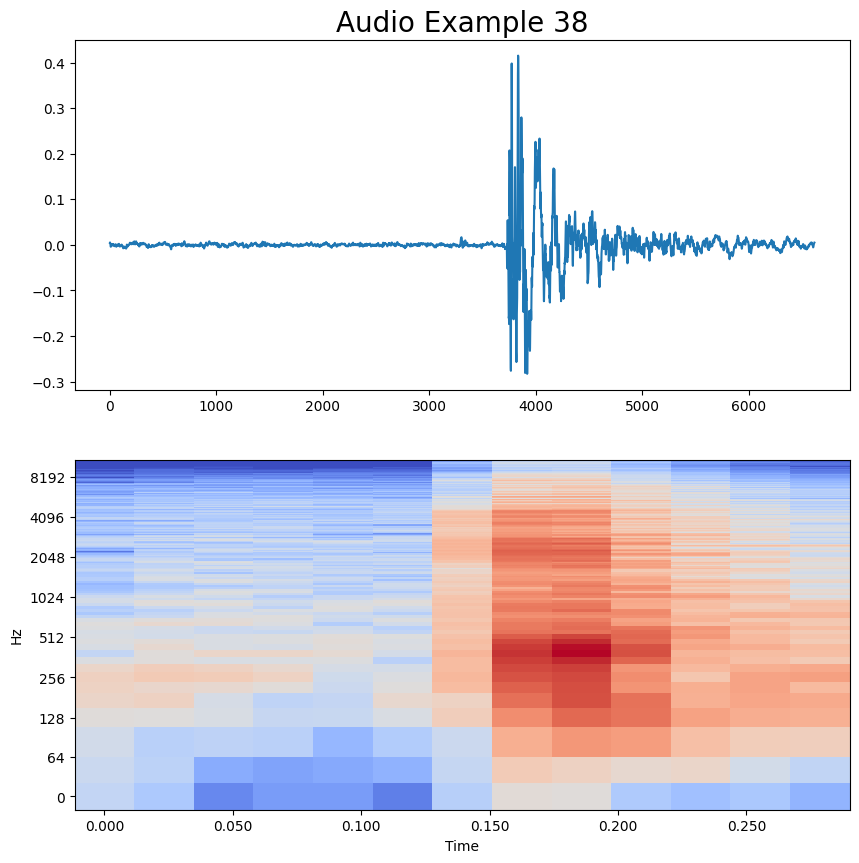

Index: 51
Has Juggle: False


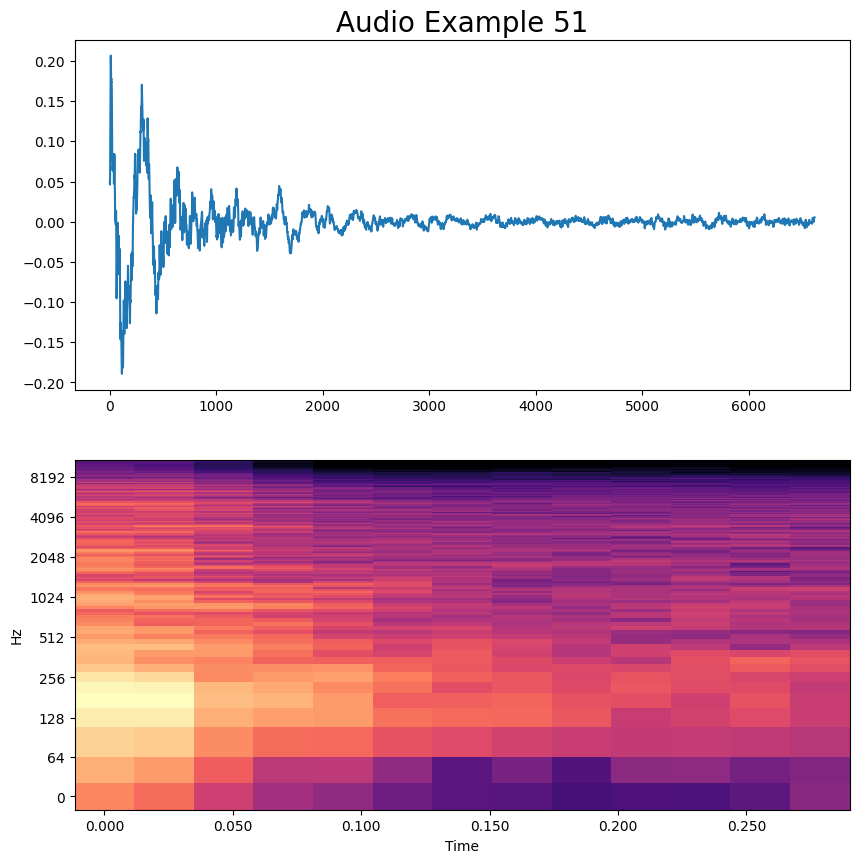

Index: 28
Has Juggle: False


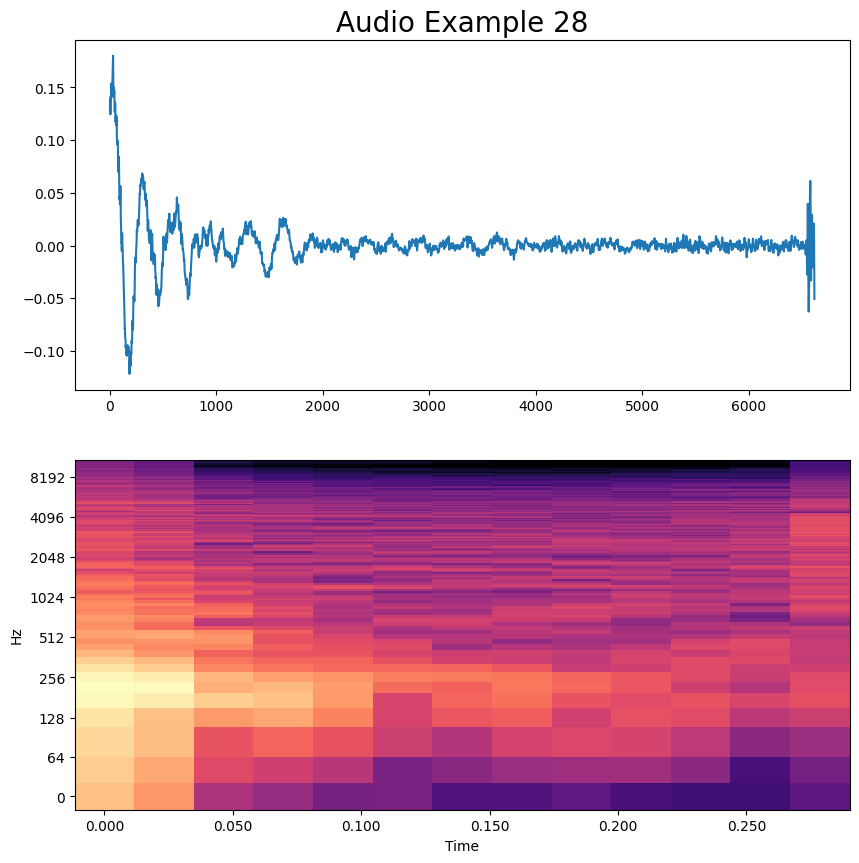

Index: 14
Has Juggle: True


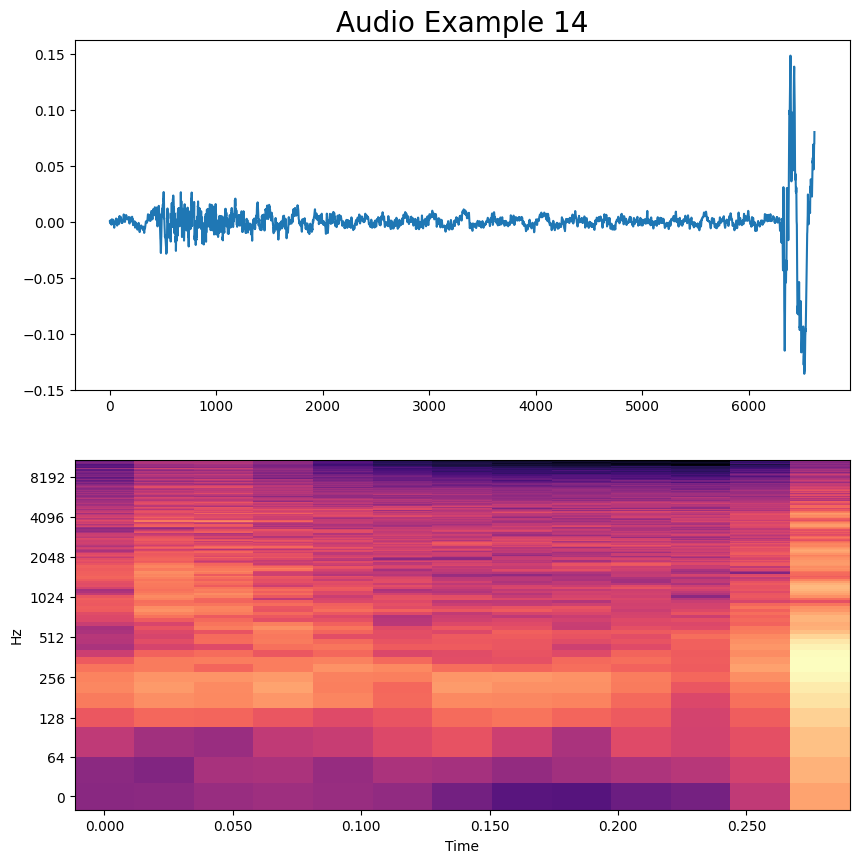

Index: 42
Has Juggle: True


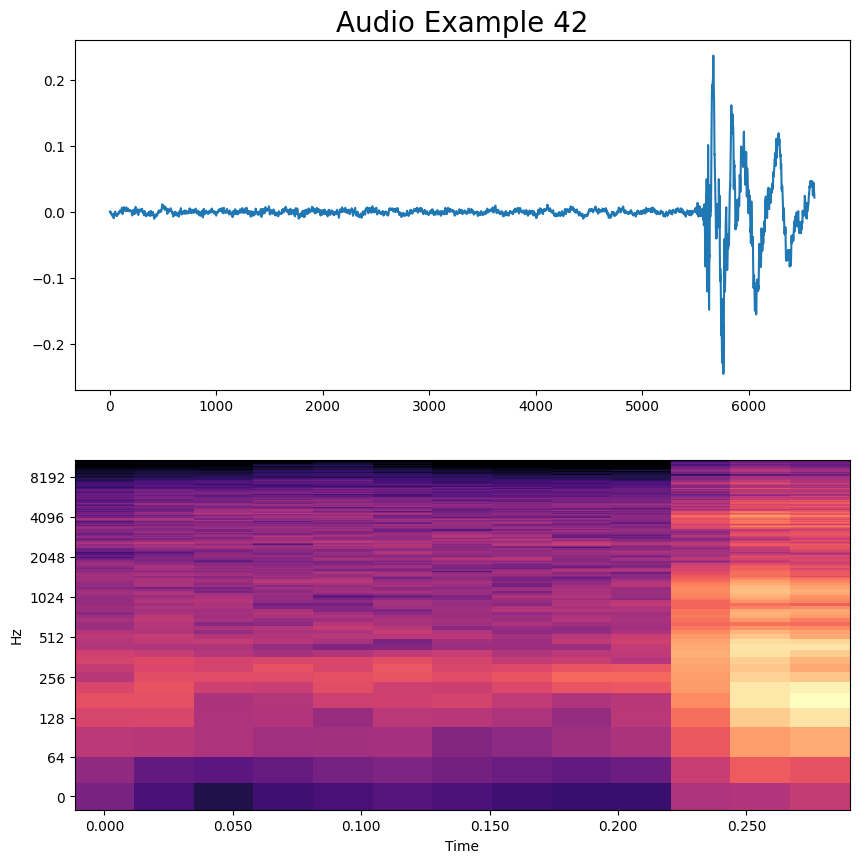

In [8]:
example = "PXL_20250222_012947893.TS_1"
# i = 2

for i in np.random.choice(
    a=list(range(tracker[example]["y"].shape[0])),
    size=5,
):
    print("Index:", i)
    print("Has Juggle:", tracker[example]["y"][i] == 1)
    # Plot the original audio data
    fig, ax = plt.subplots(figsize=(10, 10), ncols=1, nrows=2)
    ax[0].plot(tracker[example]["x"][i])
    ax[0].set_title(f'Audio Example {i}', fontsize=20)
    # Plot the transformed audio data
    img = librosa.display.specshow(tracker[example]["x_spectrogram"][i],
                                x_axis='time',
                                y_axis='log',
                                ax=ax[1])
    # ax.set_title('Spectogram Example', fontsize=20)
    # fig.colorbar(img, ax=ax[1], format=f'%0.2f')
    plt.show()

# Train, Test Split
Split on datafile; use data for testing that is in files that were not used for training.

In [9]:
files_list = list(tracker.keys())
np.random.shuffle(files_list)
train_files = files_list[:int(round(TRAIN_PROPORTION * len(files_list)))]
test_files = files_list[int(round(TRAIN_PROPORTION * len(files_list))):]

train_test = {
    "train": {
        "files": train_files,
        "x": list(),
        "x_spectrogram": list(),
        "y": list(),
    },
    "test": {
        "files": test_files,
        "x": list(),
        "x_spectrogram": list(),
        "y": list(),
    },
}

for base_name in files_list:
  for i in range(len(tracker[base_name]["x"])):
    if base_name in train_test["train"]["files"]:
      train_test["train"]["x"].append(tracker[base_name]["x"][i])
      train_test["train"]["x_spectrogram"].append(tracker[base_name]["x_spectrogram"][i])
      train_test["train"]["y"].append(tracker[base_name]["y"][i])
    else:
      train_test["test"]["x"].append(tracker[base_name]["x"][i])
      train_test["test"]["x_spectrogram"].append(tracker[base_name]["x_spectrogram"][i])
      train_test["test"]["y"].append(tracker[base_name]["y"][i])

for train_or_test in train_test:
  for x_or_y in ["x", "y"]:
    train_test[train_or_test][x_or_y] = np.array(train_test[train_or_test][x_or_y])

python_utils.custom_print(train_test)

{
  'train': {
    'files': ['PXL_20250222_013140200.TS_1', 'PXL_20250222_012947893.TS_1', 'PXL_20250223_164224211.TS_1', 'PXL_20250222_012947893.TS_2']
    'x': array([[ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00, ...,
         3.5826291e-04,  2.1329256e-04,  3.3230797e-05],
       [ 5.9663955e-05,  1.2856783e-04,  8.3404644e-05, ...,
        -2.2080618e-04, -3.5029551e-04, -3.2806024e-04],
       [-3.0868006e-04, -3.0297774e-04, -2.6701367e-05, ...,
         1.3458355e-02,  1.1900224e-02,  9.7014289e-03],
       ...,
       [ 6.0821688e-03,  5.8248728e-03,  4.8655882e-03, ...,
         3.4893106e-05,  3.0531178e-04,  7.8157627e-04],
       [ 1.4787044e-03,  1.9004552e-03,  9.4004371e-04, ...,
         7.9902442e-04,  1.5369250e-03,  2.0936434e-03],
       [ 3.2558374e-03,  3.2302993e-03,  2.0158277e-03, ...,
         0.0000000e+00,  0.0000000e+00,  0.0000000e+00]], dtype=float32)
    'x_spectrogram': [array([[-97.88714 , -97.88714 , -97.88714 , ..., -36.17741 , -32.16763 ,
       

# Train Model

In [10]:
models = dict()

## Suport Vector Machine

In [11]:
models["SVM"] = dict()
models["SVM"]["model"] = sk.svm.SVC()
models["SVM"]["model"].fit(train_test["train"]["x"], train_test["train"]["y"])
models["SVM"]["y_pred"] = models["SVM"]["model"].predict(train_test["test"]["x"])
models["SVM"]["accuracy"] = sk.metrics.accuracy_score(
    train_test["test"]["y"],
    models["SVM"]["y_pred"],
)

## CNN

In [12]:
def create_cnn_model(input_shape):
    model = tf.keras.Sequential([
        tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(input_shape[0], input_shape[1], 1)),
        tf.keras.layers.MaxPooling2D((2, 2)),
        tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
        tf.keras.layers.MaxPooling2D((2, 2)),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dense(1, activation='sigmoid')  # Binary classification, so sigmoid output
    ])
    return model

In [13]:
models["CNN"] = dict()
models["CNN"]["model"] = create_cnn_model((256, 13))
models["CNN"]["model"].compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
models["CNN"]["model"].fit(np.array(train_test["train"]["x_spectrogram"]), train_test["train"]["y"], epochs=10)
models["CNN"]["y_pred"] = models["CNN"]["model"].predict(np.array(train_test["test"]["x_spectrogram"]))
models["CNN"]["y_pred"] = (models["CNN"]["y_pred"] > 0.5).astype(int)
models["CNN"]["accuracy"] = sk.metrics.accuracy_score(
    train_test["test"]["y"],
    models["CNN"]["y_pred"],
)

/home/colin/code/bat_jester_model_training/.devenv/state/venv/lib/python3.9/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
2025-03-17 15:49:52.657119: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


Epoch 1/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 5s 93ms/step - accuracy: 0.5325 - loss: 7.8095
Epoch 2/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 3s 105ms/step - accuracy: 0.5615 - loss: 0.7147
Epoch 3/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 3s 97ms/step - accuracy: 0.6348 - loss: 0.6557
Epoch 4/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 3s 106ms/step - accuracy: 0.6165 - loss: 0.6475
Epoch 5/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 3s 110ms/step - accuracy: 0.6400 - loss: 0.6189
Epoch 6/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 97ms/step - accuracy: 0.6530 - loss: 0.6033
Epoch 7/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 3s 102ms/step - accuracy: 0.6807 - loss: 0.6098
Epoch 8/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 4s 76ms/step - accuracy: 0.6422 - loss: 0.6068
Epoch 9/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 3s 80ms/step - accuracy: 0.6809 - loss: 0.5781
Epoch 10/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 95ms/step - accuracy: 0.6730 - loss: 0.5839
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 60ms/step


## YAMNet

In [14]:
def create_yamnet_binary_classifier():
    """
    Creates a model that uses YAMNet as a feature extractor and adds a binary classification layer.
    """

    # Load YAMNet from TensorFlow Hub
    yamnet_model = hub.load("https://tfhub.dev/google/yamnet/1")

    class YAMNetBinary(tf.keras.Model):
        def __init__(self, yamnet_model):
            super(YAMNetBinary, self).__init__()
            self.yamnet = yamnet_model
            self.dense = tf.keras.layers.Dense(128, activation="relu")
            self.binary_output = tf.keras.layers.Dense(1, activation="sigmoid")

        def process_waveform(self, waveform):
            """Process a single waveform and return the embedding."""
            sample_length = tf.shape(waveform)[0]

            # Use tf.cond for conditional logic instead of Python if/else
            def truncate_fn():
                return waveform[:15600]

            def pad_fn():
                padding = tf.zeros(15600 - sample_length, dtype=tf.float32)
                return tf.concat([waveform, padding], axis=0)

            # Use tf.cond for TensorFlow-compatible conditional
            processed_waveform = tf.cond(sample_length >= 15600, truncate_fn, pad_fn)

            # Run YAMNet on this individual sample
            scores, embeddings, spectrogram = self.yamnet(processed_waveform)

            # Take the mean embedding across all frames
            mean_embedding = tf.reduce_mean(embeddings, axis=0)
            return mean_embedding

        def call(self, inputs):
            # Use tf.map_fn to process each sample in the batch
            batch_embeddings = tf.map_fn(
                self.process_waveform, inputs, fn_output_signature=tf.float32
            )

            # Binary classification layers
            x = self.dense(batch_embeddings)
            binary_predictions = self.binary_output(x)

            return binary_predictions

    model = YAMNetBinary(yamnet_model)
    return model

In [15]:
models["YAMNet"] = dict()
models["YAMNet"]["model"] = create_yamnet_binary_classifier()
models["YAMNet"]["model"].compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
models["YAMNet"]["model"].fit(np.array(train_test["train"]["x"]), train_test["train"]["y"], epochs=5)
models["YAMNet"]["y_pred"] = models["YAMNet"]["model"].predict(np.array(train_test["test"]["x"]))
models["YAMNet"]["y_pred"] = (models["YAMNet"]["y_pred"] > 0.5).astype(int)
models["YAMNet"]["accuracy"] = sk.metrics.accuracy_score(
    train_test["test"]["y"],
    models["YAMNet"]["y_pred"],
)

Epoch 1/5
25/25 ━━━━━━━━━━━━━━━━━━━━ 23s 361ms/step - accuracy: 0.5813 - loss: 0.6833
Epoch 2/5
25/25 ━━━━━━━━━━━━━━━━━━━━ 8s 256ms/step - accuracy: 0.6571 - loss: 0.6380
Epoch 3/5
25/25 ━━━━━━━━━━━━━━━━━━━━ 6s 255ms/step - accuracy: 0.6426 - loss: 0.6249
Epoch 4/5
25/25 ━━━━━━━━━━━━━━━━━━━━ 5s 207ms/step - accuracy: 0.7033 - loss: 0.6024
Epoch 5/5
25/25 ━━━━━━━━━━━━━━━━━━━━ 12s 282ms/step - accuracy: 0.6827 - loss: 0.6082
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 175ms/step


## Wavelet + RandomForest

In [16]:
class WaveletClassifier:
    def __init__(
        self, wavelet="db4", level=4, test_size=0.2, random_state=42, n_estimators=100
    ):
        """
        Initialize the wavelet classifier.

        Parameters:
        -----------
        wavelet : str, default="db4"
            The wavelet to use for feature extraction
        level : int, default=4
            The level of wavelet decomposition
        test_size : float, default=0.2
            The proportion of the dataset to include in the test split
        random_state : int, default=42
            Controls the randomness of the classifier
        n_estimators : int, default=100
            The number of trees in the forest
        """
        self.wavelet = wavelet
        self.level = level
        self.test_size = test_size
        self.random_state = random_state
        self.n_estimators = n_estimators
        self.clf = None
        self.scaler = None

    def _wavelet_feature_extraction(self, audio_data):
        """Extracts wavelet features from audio data."""
        coeffs = pywt.wavedec(audio_data, self.wavelet, level=self.level)
        features = np.concatenate(
            [np.atleast_1d(np.mean(np.abs(c), axis=0)) for c in coeffs]
        )
        return features

    def fit(self, X, y):
        """
        Train the classifier on the input data.

        Parameters:
        -----------
        X : array-like of shape (n_samples, n_features)
            The training audio data
        y : array-like of shape (n_samples,)
            The target labels

        Returns:
        --------
        self : object
            Returns self
        """
        features = np.array([self._wavelet_feature_extraction(audio) for audio in X])

        # Standardize features
        self.scaler = sk.preprocessing.StandardScaler()
        features = self.scaler.fit_transform(features)

        X_train, X_test, y_train, y_test = sk.model_selection.train_test_split(
            features, y, test_size=self.test_size, random_state=self.random_state
        )

        # Train a classifier (Random Forest in this example)
        self.clf = sk.ensemble.RandomForestClassifier(
            n_estimators=self.n_estimators, random_state=self.random_state
        )
        self.clf.fit(X_train, y_train)

        # Evaluate on test set
        y_pred = self.clf.predict(X_test)
        accuracy = sk.metrics.accuracy_score(y_test, y_pred)
        print(f"Test Accuracy: {accuracy}")

        return self

    def predict(self, X):
        """
        Predict labels for the input data.

        Parameters:
        -----------
        X : array-like of shape (n_samples, n_features)
            The input audio data

        Returns:
        --------
        y : array-like of shape (n_samples,)
            The predicted labels
        """
        if self.clf is None:
            raise ValueError("Classifier not fitted. Call fit first.")

        if isinstance(X, list) or (
            isinstance(X, np.ndarray) and len(X.shape) > 1 and X.ndim > 1
        ):
            # Multiple samples
            predictions = []
            for audio in X:
                feature = self._wavelet_feature_extraction(audio).reshape(1, -1)
                feature = self.scaler.transform(feature)
                predictions.append(self.clf.predict(feature)[0])
            return np.array(predictions)
        else:
            # Single sample
            feature = self._wavelet_feature_extraction(X).reshape(1, -1)
            feature = self.scaler.transform(feature)
            return self.clf.predict(feature)[0]

In [17]:
models["Wavelet"] = dict()
models["Wavelet"]["model"] = WaveletClassifier(wavelet="db4", level=4)
models["Wavelet"]["model"].fit(train_test["train"]["x"], train_test["train"]["y"])
models["Wavelet"]["y_pred"] = models["Wavelet"]["model"].predict(train_test["test"]["x"])
models["Wavelet"]["accuracy"] = sk.metrics.accuracy_score(
    train_test["test"]["y"],
    models["Wavelet"]["y_pred"],
)

Test Accuracy: 0.6962025316455697


# Evaluate Models

## Accuracy

In [18]:
for model in models:
  print(f"{model}: {models[model]['accuracy']}")

SVM: 0.85546875
CNN: 0.64453125
YAMNet: 0.7890625
Wavelet: 0.8125


## Visualize Predictions

In [19]:
NUM_VISUALIZATIONS = 10

In [20]:
def plot_examples(x_test, y_test, models, indices_to_plot, num_visualizations, ylim = 0.5):
  num_plots = min(len(indices_to_plot), num_visualizations)
  fig, ax = plt.subplots(
      figsize=(10, 30),
      nrows=num_plots,
      ncols=1,
  )
  for i in range(num_plots):
    pd.Series(x_test[indices_to_plot[i]]).plot(
        lw=1,
        color='blue',
        ax=ax[i],
        label=f"Actual: {y_test[indices_to_plot[i]]}, Predictions: " + str([f"{model}: {models[model]['y_pred'][indices_to_plot[i]]}" for model in models]),
    )
    ax[i].legend()
    ax[i].set_ylim(-ylim, ylim)
  plt.show()

## Random Sample

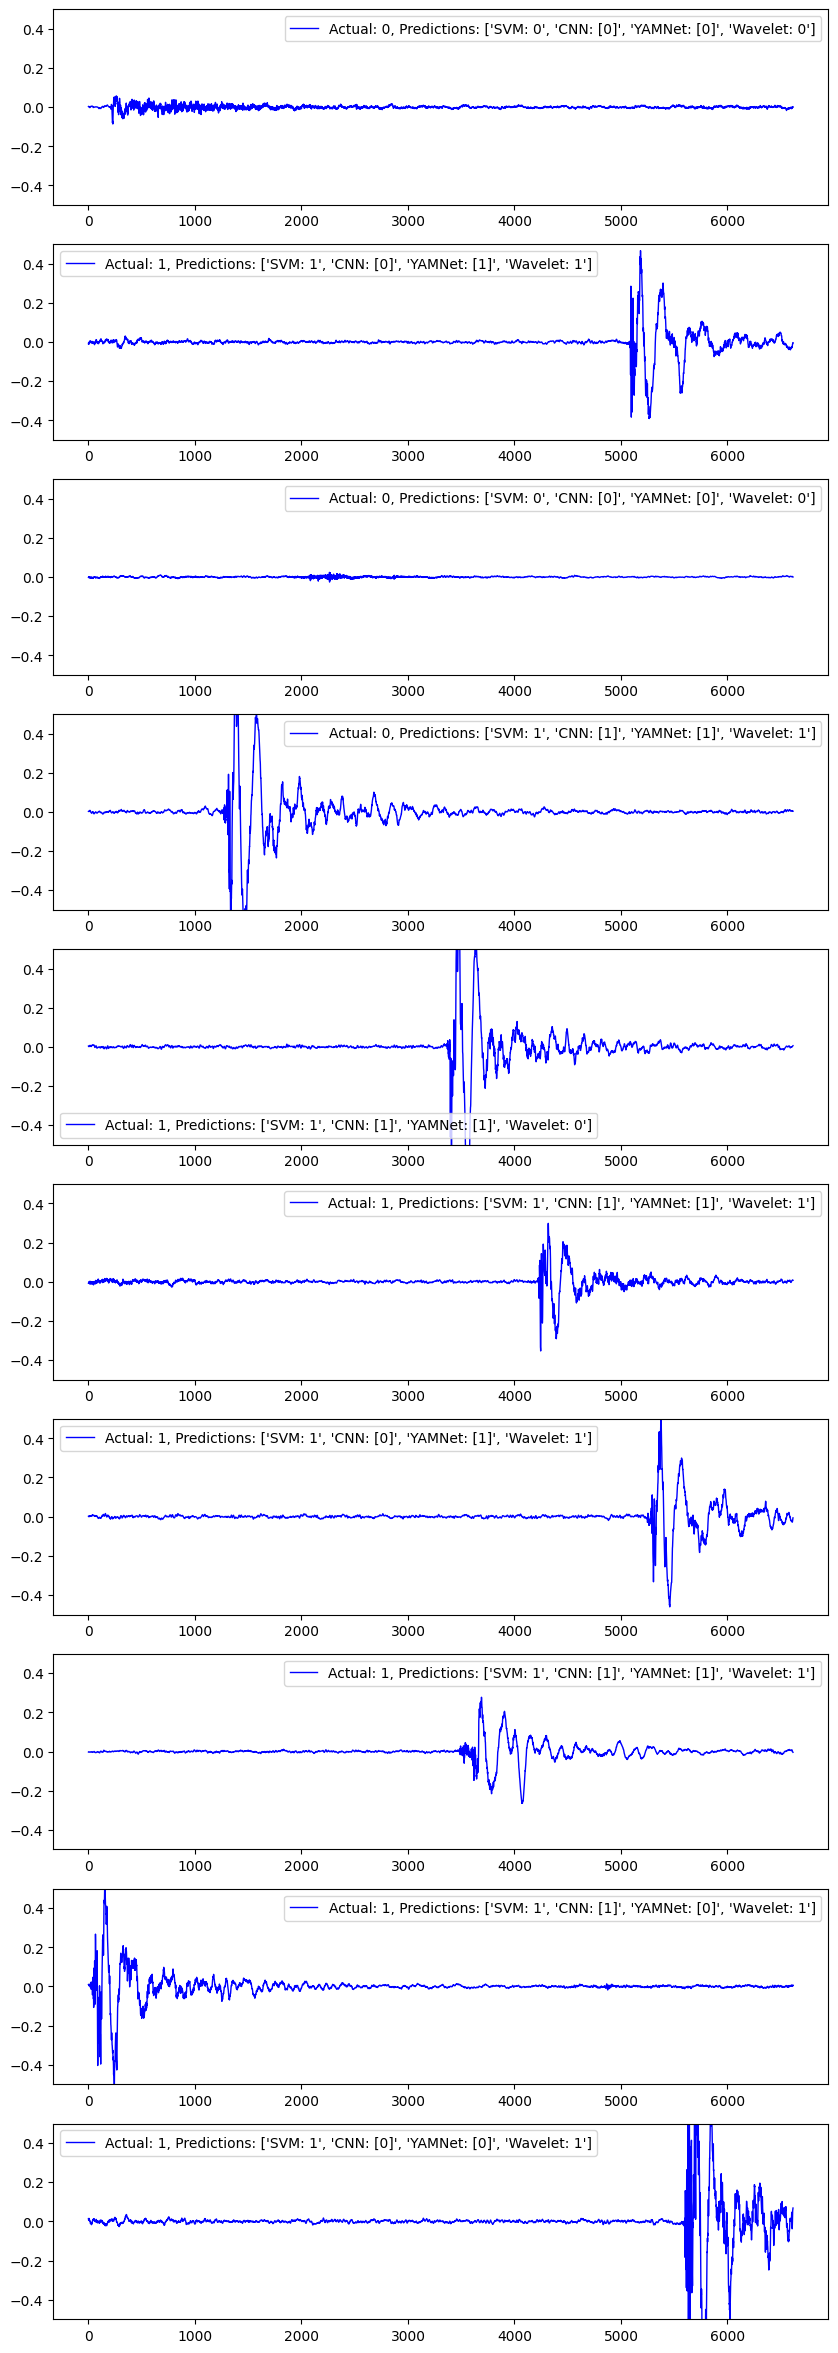

In [21]:
random_indices = np.random.choice(
    train_test["test"]["x"].shape[0],
    NUM_VISUALIZATIONS,
    replace=False,
    )

plot_examples(
    x_test=train_test["test"]["x"],
    y_test=train_test["test"]["y"],
    models=models,
    indices_to_plot=random_indices,
    num_visualizations=NUM_VISUALIZATIONS,
)

# Save Models for Deployment

In [22]:
# Convert the model to ONNX
initial_type = [('float_input', skl2onnx.common.data_types.FloatTensorType([None, train_test["train"]["x"][0].shape[0]])) ] #Replace X.shape[1] with the correct shape.
onnx_model = skl2onnx.convert_sklearn(models["SVM"]["model"], initial_types=initial_type)

# Save the ONNX model
with open(os.path.join(TRAINED_MODELS_DIR, f'model_svm_{pd.Timestamp.now()}.onnx'), 'wb') as f:
    f.write(onnx_model.SerializeToString())